In [1]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird

from scipy.special import legendre
from scipy.interpolate import interp1d

In [2]:
font = {'size': 14, 'family': 'serif'}
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
matplotlib.mathtext.rcParams["mathtext.fontset"]='cm'

In [3]:
zpk = 0.5
kd = np.arange(0.01, 0.31, 0.005)
sd = np.arange(5, 200, 1)

In [4]:
from classy import Class
M = Class()
M.set({'omega_b': 0.02237, 'omega_cdm': 0.120, 'h': 0.6736, 'ln10^{10}A_s': 3.044, 'n_s': 0.9649})
M.set({'output': 'mPk', 'P_k_max_1/Mpc': 1.0, 'z_max_pk': zpk})
M.compute()
f1 = M.scale_independent_growth_factor_f(zpk) # growth rate
kk = np.logspace(-5, 0, 200) # k in h/Mpc
pklin = np.array([M.pk(k*M.h(), zpk)*M.h()**3 for k in kk]) # P(k) in (Mpc/h)**3
ipklin = interp1d(kk, pklin, axis=-1, kind='cubic', bounds_error=False, fill_value=0)

In [5]:
def get_cov_ps(kk, ipklin, Vs=5e9, nbar=3.e-4, b1=2, f1=f1):
    dk = np.concatenate((kk[1:]-kk[:-1], [kk[-1]-kk[-2]])) # this is true for k >> kf
    Nmode = 4 * np.pi * kk**2 * dk * (Vs / (2*np.pi)**3)
    mu = np.linspace(0., 1., 200)
    k_mesh, mu_mesh = np.meshgrid(kk, mu, indexing='ij')
    legendre_mesh = np.array([legendre(2*l)(mu_mesh) for l in range(3)])
    legendre_ell_mesh = np.array([(2*(2*l)+1)*legendre(2*l)(mu_mesh) for l in range(3)])
    pkmu_mesh = (b1 + f1 * mu_mesh**2)**2 * ipklin(k_mesh)
    integrand_mu_mesh = np.einsum('k,km,lkm,pkm->lpkm', 1./Nmode, (pkmu_mesh + 1/nbar)**2, legendre_ell_mesh, legendre_ell_mesh)
    cov_diagonal = 2 * np.trapz(integrand_mu_mesh, x=mu, axis=-1)
    return np.block([[np.diag(cov_diagonal[i,j]) for i in range(3)] for j in range(3)]) 

err = np.sqrt(np.diag(get_cov_ps(kd, ipklin))).reshape(3,-1)


In [6]:
import pybird
N = pybird.Correlator()
N.info()



Configuration commands [.set(config_dict)]
----------------------
'output': ['str'] ; options: ['bPk', 'bCf', 'mPk', 'mCf', 'bmPk', 'bmCf']
    - Correlator: biased tracers / matter / biased tracers-matter -- power spectrum / correlation function.
    * default: bPk
'multipole': ['int'] ; options: [0, 2, 3]
    - Number of multipoles. 0: real space. 2: monopole + quadrupole. 3: monopole + quadrupole + hexadecapole.
    * default: 2
'wedge': ['int']
    - Number of wedges. 0: compute multipole instead. 
    * default: 0
'wedges_bounds': ['list', 'ndarray']
    - Wedges bounds: [0, a_1, ..., a_{n-1}, 1], n: number of wedges, such that 0 < mu < a_1, ..., a_{n-1} < mu < 1. Default: equi-spaced between 0 and 1.
    * default: None
'skycut': ['int']
    - Number of skycuts.
    * default: 1
'z': ['float', 'list', 'ndarray']
    - Effective redshift(s). Should match the number of skycuts.
    * default: None
'km': ['float']
    - Inverse tracer spatial extension scale in [h/Mpc].
    * defa

In [7]:
# pk
N = pybird.Correlator()
N.set({'output': 'bPk', 'xdata': kd, 'km': 0.7, 'kr': 0.35})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pk = N.get({ "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2, "cr1": -1.6, "cr2": 0.})

# pk
N = pybird.Correlator()
N.set({'output': 'bPk', 'xdata': kd, 'km': 0.7, 'kr': 0.35})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pknorsd = N.get({ "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2, "cr1": 0., "cr2": 0.})


N = pybird.Correlator()
N.set({'output': 'bPk', 'xdata': kd, 'km': 0.7, 'kr': 0.35, 'with_nnlo_counterterm': True})
N.compute({'k11': kk, 'P11': pklin, 'f': f1, 'Psmooth': pklin})
pknnlo = N.get({ "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2, "cr1": -1.6, "cr2": 0., 
                "cr4": -1, "cr6": 0.})

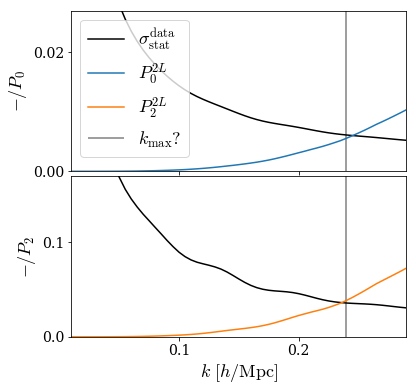

In [155]:
fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True, gridspec_kw = {'wspace':0., 'hspace':0.03})

for i, c in enumerate(['C0', 'C1']): 
    # ax[i].plot(kd, np.abs((pknorsd[i]-pk[i]) / pk[i]), label='')
    ax[i].plot(kd, err[i]/pk[i], 'k-', label=r'$\sigma_{\rm stat}^{\rm data}$')
    ax[i].plot(kd, np.abs((pknnlo[i]-pk[i]) / pk[i]), label='$P^{2L}_0$', color=c)
    ax[i].vlines(0.24, 0, 0.2, color='gray', label=r'$k_{\rm max}?$')
    ax[i].set_xlim(0.01, 0.29)

ax[0].plot(kd, np.ones_like(kd), color='C1', label=r'$P^{2L}_2$')
ax[0].set_ylim(0, .027)
ax[1].set_ylim(0., .17)
ax[1].set_xlabel(r'$k \ [h/{\rm Mpc}]$', fontsize=18)
ax[1].set_xticks([0.1, 0.2])
ax[0].set_yticks([0., 0.02])
ax[1].set_yticks([0., 0.1])
ax[0].set_ylabel(r'$-/P_0$', fontsize=18)
ax[1].set_ylabel(r'$-/P_2$', fontsize=18)

ax[0].legend(loc='upper left', fontsize=18)
plt.savefig('/Users/Pierre/Desktop/prez/nnlo.pdf', bbox_inches='tight')